<div style="border: 5px solid #000000;background-color: beige;padding: 10px;">

<h1 style="color:blue; text-align:center;">IDD IDENTIFICATION FOR REST-EEG</h1>
 
</div>

## Data Loading and Preprocessing

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import scipy.io
import mne
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, concatenate, GRU, Conv1D, Dropout
from tensorflow.keras.models import Model
import contextlib
import io
from sklearn.metrics import accuracy_score, precision_score

IDD_data_path = './DATASET/Data/CleanData/CleanData_IDD/Rest'
TDC_data_path = './DATASET/Data/CleanData/CleanData_TDC/Rest'
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

def convertmat2mne(data):
    ch_types = ['eeg'] * 14
    info = mne.create_info(channel_names, ch_types=ch_types, sfreq=128)
    info.set_montage('standard_1020')
    data = mne.io.RawArray(data, info)
    data.set_eeg_reference()
    data.notch_filter(freqs=50)
    data.filter(l_freq=1, h_freq=30)
    return mne.make_fixed_length_epochs(data, duration=4).get_data()

@contextlib.contextmanager
def suppress_stdout():
    stdout = io.StringIO()
    with contextlib.redirect_stdout(stdout):
        yield

idd_subject, tdc_subject = [], []
for idd in glob(IDD_data_path + '/*.mat'):
    with suppress_stdout():
        idd_subject.append(convertmat2mne(scipy.io.loadmat(idd)['clean_data']))
for tdc in glob(TDC_data_path + '/*.mat'):
    with suppress_stdout():
        tdc_subject.append(convertmat2mne(scipy.io.loadmat(tdc)['clean_data']))

control_labels = [len(i) * [0] for i in tdc_subject]
patient_labels = [len(i) * [1] for i in idd_subject]
data_list = tdc_subject + idd_subject
label_list = control_labels + patient_labels
groups_list = [[i] * len(j) for i, j in enumerate(data_list)]
data_array = np.moveaxis(np.concatenate(data_list), 1, 2)
label_array, group_array = np.concatenate(label_list), np.concatenate(groups_list)


## Feature Extraction and Channel Selection

In [3]:
feature_list, feature_names = [], []

for i in range(14):
    channel_mean = np.mean(data_array[:, :, i], axis=1)
    channel_var = np.var(data_array[:, :, i], axis=1)
    feature_list.extend([channel_mean, channel_var])
    feature_names.extend([f'{channel_names[i]}_mean', f'{channel_names[i]}_var'])

features_df = pd.DataFrame(np.array(feature_list).T, columns=feature_names)
correlation_values = [abs(np.corrcoef(features_df[f], label_array)[0, 1]) for f in feature_names]

correlation_df = pd.DataFrame({'Feature': feature_names, 'Correlation': correlation_values})
correlation_df['Channel'] = correlation_df['Feature'].str.extract(r'(AF3|F7|F3|FC5|T7|P7|O1|O2|P8|T8|FC6|F4|F8|AF4)')
channel_correlation = correlation_df.groupby('Channel')['Correlation'].max().reset_index()
top_channels = channel_correlation.sort_values(by='Correlation', ascending=False).head(8)['Channel'].tolist()
selected_indices = [channel_names.index(ch) for ch in top_channels]
data_array_selected = data_array[:, :, selected_indices]

class StandardScaler3D(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self, X):
        return self.scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)

gkf = GroupKFold()
accuracy, precision_scores = [], []


In [21]:
print(top_channels)

['T8', 'FC6', 'F4', 'AF4', 'P8', 'AF3', 'FC5', 'F3']


## Model Training, Evaluation, and Plotting

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 486ms/step - accuracy: 0.5174 - loss: 0.6737 - val_accuracy: 0.6000 - val_loss: 0.6790
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7710 - loss: 0.6130 - val_accuracy: 0.7222 - val_loss: 0.6354
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9340 - loss: 0.4827 - val_accuracy: 0.7556 - val_loss: 0.5456
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9521 - loss: 0.3096 - val_accuracy: 0.7667 - val_loss: 0.4850
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9776 - loss: 0.1621 - val_accuracy: 0.8111 - val_loss: 0.3998
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9858 - loss: 0.0842 - val_accuracy: 0.6889 - val_loss: 0.9710
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9900 - loss: 0.0409 - val_accuracy: 0.8556 - val_loss: 0.4175
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9882 - loss: 0.0391 - val_accuracy: 0.6889 - val_loss:

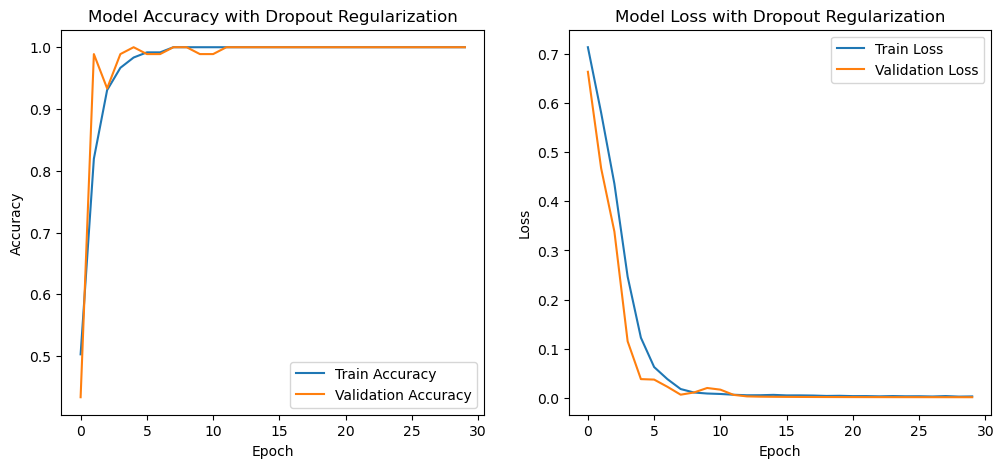

Average Accuracy:  0.9422222222222223
Average Precision:  0.9423981251723188


In [7]:
for train_index, val_index in gkf.split(data_array_selected, label_array, groups=group_array):
    train_features, train_labels = data_array_selected[train_index], label_array[train_index]
    val_features, val_labels = data_array_selected[val_index], label_array[val_index]

    scaler = StandardScaler3D()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)

    def block(input):
        conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
        conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
        conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
        return concatenate([conv1, conv2, conv3], axis=2)

    input = Input(shape=(512, 8))
    block1 = block(input)
    block2 = block(block1)
    block3 = block(block2)

    gru_out1 = GRU(32, activation='tanh', return_sequences=True)(block3)
    gru_out2 = GRU(32, activation='tanh', return_sequences=True)(gru_out1)
    gru_out = concatenate([gru_out1, gru_out2], axis=2)
    gru_out3 = GRU(32, activation='tanh', return_sequences=True)(gru_out)
    gru_out = concatenate([gru_out1, gru_out2, gru_out3])
    gru_out4 = GRU(32, activation='tanh')(gru_out)

    dropout = Dropout(0.5)(gru_out4)
    predictions = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs=input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_features, train_labels, epochs=30, batch_size=128, validation_data=(val_features, val_labels))

    val_predictions = (model.predict(val_features) > 0.5).astype(int)
    accuracy.append(accuracy_score(val_labels, val_predictions))
    precision_scores.append(precision_score(val_labels, val_predictions))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Dropout Regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Dropout Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print("Average Accuracy: ", np.mean(accuracy))
print("Average Precision: ", np.mean(precision_scores))


## Saving Model

In [9]:
# Save the trained model
model.save('idd_model.h5')

## Testing and Predicting

In [36]:
import numpy as np
import scipy.io
import mne
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tkinter as tk
from tkinter import filedialog

model = load_model('idd_model.h5')

def extract_top_channels(eeg_data, top_channels, channel_names):
    selected_indices = [channel_names.index(ch) for ch in top_channels]
    return eeg_data[:, selected_indices, :]

def predict_idd(uploaded_eeg_path):
    eeg_data = scipy.io.loadmat(uploaded_eeg_path)['clean_data']
    channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    ch_types = ['eeg'] * 14
    sampling_freq = 128
    info = mne.create_info(channel_names, ch_types=ch_types, sfreq=sampling_freq)
    info.set_montage('standard_1020')
    data = mne.io.RawArray(eeg_data, info)
    data.set_eeg_reference()
    data.notch_filter(freqs=50)
    data.filter(l_freq=1, h_freq=30)
    epochs = mne.make_fixed_length_epochs(data, duration=4, overlap=0)
    eeg_data = epochs.get_data()
    eeg_data_selected = extract_top_channels(eeg_data, top_channels, channel_names)

    class StandardScaler3D:
        def __init__(self):
            self.scaler = StandardScaler()
    
        def fit(self, X):
            self.scaler.fit(X.reshape(-1, X.shape[2]))
            return self
    
        def transform(self, X):
            return self.scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
    
        def fit_transform(self, X):
            return self.scaler.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)

    scaler = StandardScaler3D()
    eeg_data_scaled = scaler.fit_transform(eeg_data_selected)

    if eeg_data_scaled.shape[0] > 1:
        eeg_data_scaled = eeg_data_scaled[0:1]
        eeg_data_scaled = eeg_data_scaled.transpose(0, 2, 1)

    prediction_probs = model.predict(eeg_data_scaled)
    prediction = (prediction_probs > 0.7).astype(int)
    prediction_percentage = prediction_probs[0][0] * 100

    if prediction[0] == 1:
        print(f"Prediction: IDD detected! (Probability: {prediction_percentage:.2f}%)")
    else:
        print(f"Prediction: No IDD detected! (Probability: {prediction_percentage:.2f}%)")
    
    return prediction, prediction_percentage

def upload_and_predict():
    file_path = filedialog.askopenfilename(title="Select EEG MAT file", filetypes=[("MAT files", "*.mat")])
    if file_path:
        prediction, prediction_percentage = predict_idd(file_path)
        result_label.config(text=f"Prediction: {'IDD detected' if prediction[0] == 1 else 'No IDD detected'}\nProbability: {prediction_percentage:.2f}%")

root = tk.Tk()
root.title("IDD Prediction from EEG")

upload_button = tk.Button(root, text="Upload EEG Signal", command=upload_and_predict)
upload_button.pack(pady=20)

result_label = tk.Label(root, text="Prediction: Not yet predicted")
result_label.pack(pady=10)

root.mainloop()


Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wi